In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.python.keras.callbacks import EarlyStopping,CSVLogger
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
import tensorflow as tf
import pickle
from matplotlib import pyplot as plt
import numpy as np
from equation_as2 import equation

In [2]:
# add to the top of your code under import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
train_x = pickle.load(open('./Data/train_pairs.pickle','rb'))
train_y = pickle.load(open('./Data/train_y.pickle','rb'))
test_x1 = pickle.load(open('./Data/test_pairs1.pickle','rb'))
test_y1 = pickle.load(open('./Data/test_y1.pickle','rb'))
test_x2 = pickle.load(open('./Data/test_pairs2.pickle','rb'))
test_y2 = pickle.load(open('./Data/test_y2.pickle','rb'))
test_x3 = pickle.load(open('./Data/test_pairs3.pickle','rb'))
test_y3 = pickle.load(open('./Data/test_y3.pickle','rb'))

In [4]:
train_x = train_x.astype('float32')
test_x1 = test_x1.astype('float32')
test_x2 = test_x2.astype('float32')
test_x3 = test_x3.astype('float32')
train_x /= 255
test_x1 /= 255
test_x2 /= 255
test_x3 /= 255

In [5]:
img_rows, img_cols = train_x.shape[2:4]
train_x = train_x.reshape(train_x.shape[0], 2 ,img_rows, img_cols, 1)
test_x1 = test_x1.reshape(test_x1.shape[0],2, img_rows, img_cols, 1)
test_x2 = test_x2.reshape(test_x2.shape[0],2, img_rows, img_cols, 1)
test_x3 = test_x3.reshape(test_x3.shape[0],2, img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [51]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 0.7
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


In [52]:
def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input_tensor = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation='relu',name='block1_conv1')(input_tensor)
    x = Conv2D(16, (3, 3), activation='relu',name='block1_conv2')(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block1_pool')(x)
    x = Conv2D(32, (3, 3), activation='relu',name='block2_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu',name='block2_conv2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2),name = 'block2_pool')(x)
    x = Flatten()(x)
    output = Dense(128, activation='relu',name = 'embeding',kernel_regularizer=regularizers.l2(0.01),
                 activity_regularizer= regularizers.l2(0.01))(x)    
    return Model(input_tensor, output)

In [53]:
base_network = create_base_network(input_shape)
base_network.summary()
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 26, 26, 8)         80        
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 24, 24, 16)        1168      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 12, 12, 16)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 10, 10, 32)        4640      
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 8, 8, 64)          18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 64)          256

In [54]:
# train
epochs = 200
adam = Adam(learning_rate=1e-4,decay=1e-6/epochs)
model.compile(loss=contrastive_loss, optimizer=adam, metrics=[accuracy])

In [55]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('./Data/Model2.log')
history = model.fit([train_x[:, 0], train_x[:, 1]], train_y,
          batch_size=128,
          epochs=epochs,
          validation_split=0.1,
          callbacks=[early_stopping_callback,csv_logger])

Train on 60145 samples, validate on 6683 samples
Epoch 1/200
60145/60145 [==============================] - 9s 147us/sample - loss: 2.0589 - accuracy: 0.6281 - val_loss: 1.2583 - val_accuracy: 0.8518
Epoch 2/200
60145/60145 [==============================] - 8s 140us/sample - loss: 0.9247 - accuracy: 0.8416 - val_loss: 0.6749 - val_accuracy: 0.9209
Epoch 3/200
60145/60145 [==============================] - 8s 137us/sample - loss: 0.5128 - accuracy: 0.8779 - val_loss: 0.3810 - val_accuracy: 0.9447
Epoch 4/200
60145/60145 [==============================] - 8s 139us/sample - loss: 0.2978 - accuracy: 0.8968 - val_loss: 0.2226 - val_accuracy: 0.9570
Epoch 5/200
60145/60145 [==============================] - 8s 140us/sample - loss: 0.1781 - accuracy: 0.9060 - val_loss: 0.1318 - val_accuracy: 0.9688
Epoch 6/200
60145/60145 [==============================] - 8s 140us/sample - loss: 0.1105 - accuracy: 0.9124 - val_loss: 0.0812 - val_accuracy: 0.9621
Epoch 7/200
60145/60145 [====================

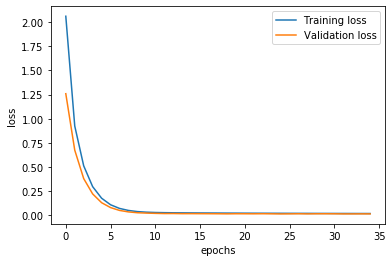

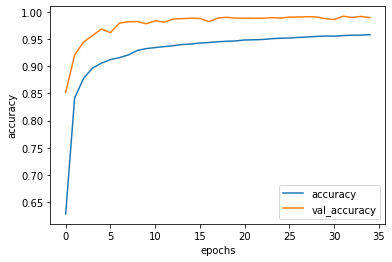

In [56]:
loss = history.history['loss'].copy()
val_loss= history.history['val_loss'].copy()
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['Training loss','Validation loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()
accuracy = history.history['accuracy'].copy()
val_accuracy = history.history['val_accuracy'].copy()
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.legend(['accuracy','val_accuracy'])
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [57]:
test_x1[:1,0].shape

(1, 28, 28, 1)

In [58]:
pred1 = model.predict([test_x1[:,0],test_x1[:,1]])
pred2 = model.predict([test_x2[:,0],test_x2[:,1]])
pred3 = model.predict([test_x3[:,0],test_x3[:,1]])

In [59]:
te_acc1 = compute_accuracy(test_y1, pred1)
te_acc2 = compute_accuracy(test_y2, pred2)
te_acc3 = compute_accuracy(test_y3, pred3)
print('* Accuracy on test1 set: %0.2f%%' % (100 * te_acc1))
print('* Accuracy on test2 set: %0.2f%%' % (100 * te_acc2))
print('* Accuracy on test3 set: %0.2f%%' % (100 * te_acc3))

* Accuracy on test1 set: 95.27%
* Accuracy on test2 set: 69.46%
* Accuracy on test3 set: 82.13%


In [ ]:
index = 22
print(test_y2[index])
plt.imshow(np.reshape(test_x2[index,0],(28,28))*255,cmap = 'gray')
plt.show()
plt.imshow(np.reshape(test_x2[index,1],(28,28))*255,cmap = 'gray')
plt.show()

In [60]:
model.save('./Data/model2_m0.7.h5')